# Augmented Noise HuBERT-SER model

This technique simulates environmental
conditions by introducing controlled background noise into
the speech waveform, reflecting scenarios where speech oc-
curs amidst ambient sounds, such as traffic or crowd chatter.
The primary parameter is the signal-to-noise ratio (SNR), in-
dicating the noise intensity relative to the clean speech signal.
Training on moderately noisy samples enhances the model’s
robustness to real-world acoustic variability while preserving
the intelligibility of emotional cues.

#### **Flow**:

This program will follow the steps:
1. General Preparation  
2. Data Processing
3. Augmentation Method - copyPaste - ncp  
5. Loading the Model and Optimizer
6. Training
7. Testing
8. Testing all test sets

## 1. General Preparation

In [ ]:
# Install required packages
%%capture
!pip install datasets transformers evaluate accelerate torch
!pip install torch torchaudio

Import some common libraries.

In [ ]:
import time
from tqdm import tqdm
import torch
import os
import soundfile as sf
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import Wav2Vec2FeatureExtractor, HubertForSequenceClassification
from datasets import Dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader
import librosa
from sklearn.metrics import classification_report, confusion_matrix
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio


Use GPU Facilities.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Set Seed for Reproducibility

In [ ]:
SEED = 42

def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(SEED)

Mount drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = "/content/drive/MyDrive/YourProject"

## 2. Data Processing

### 2.1 Load RAVDESS dataset

Download dataset file from website https://zenodo.org/record/1188976

In [ ]:
%%capture
![ -f Audio_Speech_Actors_01-24.zip ] && echo "File existed" || wget "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1" -O Audio_Speech_Actors_01-24.zip

Unzip dataset file.

In [ ]:
%%capture
![ -f "./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav" ] && echo "File existed" || unzip Audio_Speech_Actors_01-24.zip -d "./Audio_Speech_Actors_01-24/"

### 2.2 Create RAVDESS data frame

In [ ]:
# Process dataset
RAV = "./Audio_Speech_Actors_01-24/"
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
   fname = os.listdir(RAV + i)
   for f in fname:
       part = f.split('.')[0].split('-')
       emotion.append(int(part[2]))
       temp = int(part[6])
       gender.append("female" if temp%2 == 0 else "male")
       path.append(RAV + i + '/' + f)

# Create DataFrame
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df, pd.DataFrame(emotion)],axis=1)
RAV_df.columns = ['gender','emotion','labels']
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df.emotion.value_counts()

,count
emotion,
sad,192
surprise,192
calm,192
angry,192
happy,192
disgust,192
fear,192
neutral,96


In [ ]:
RAV_df

,gender,emotion,labels,source,path
0,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...
1,male,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-08-...
2,male,calm,2,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-02-...
3,male,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-08-...
4,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...
...,...,...,...,...,...
1435,female,calm,2,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-02-...
1436,female,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-03-...
1437,female,disgust,7,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-07-...
1438,female,calm,2,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-02-...


In our project we examine 7 emotions:

In [ ]:
RAV_df = RAV_df[
   (RAV_df["emotion"]=="neutral") |
   (RAV_df["emotion"]=="happy") |
   (RAV_df["emotion"]=="sad") |
   (RAV_df["emotion"]=="angry") |
   (RAV_df["emotion"]=="fear") |
   (RAV_df["emotion"]=="disgust") |
   (RAV_df["emotion"]=="surprise")
]
print(f"Shape of data frame: {RAV_df.shape}")
RAV_df.emotion.value_counts()

Shape of data frame: (1248, 5)


,count
emotion,
sad,192
surprise,192
angry,192
happy,192
disgust,192
fear,192
neutral,96


### 2.3 Spliting the data
Split into training (80%) and test (20%) data.

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming RAV_df has a column named 'labels' for stratification
train_df, test_df = train_test_split(
    RAV_df,
    test_size=0.2,
    random_state=42,
    stratify=RAV_df['emotion']
)

Let's have a look at the training data.

In [ ]:
train_df

,gender,emotion,labels,source,path
316,female,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_06/03-01-03-...
992,male,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_17/03-01-03-...
945,female,angry,5,RAVDESS,./Audio_Speech_Actors_01-24/Actor_16/03-01-05-...
285,male,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_05/03-01-08-...
130,male,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_03/03-01-08-...
...,...,...,...,...,...
381,male,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_07/03-01-08-...
1079,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_18/03-01-04-...
1188,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_20/03-01-04-...
1070,female,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_18/03-01-08-...


In [ ]:
train_df["emotion"].value_counts()

,count
emotion,
angry,154
surprise,154
disgust,154
happy,153
fear,153
sad,153
neutral,77


In [ ]:
# Display the first data.
import IPython.display as ipd
id = 0
print(train_df.iloc[id])
ipd.Audio(data=train_df.iloc[id]["path"], autoplay=True, rate=16000)

gender                                                female
emotion                                                happy
labels                                                     3
source                                               RAVDESS
path       ./Audio_Speech_Actors_01-24/Actor_06/03-01-03-...
Name: 316, dtype: object


### Save and load

In [ ]:
# Save the DataFrames with the paths
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')
print("DataFrames saved as pickle files.")
# Save training and testing datasets
train_df.to_csv("train_df_clean.csv", index=False)
test_df.to_csv("test_df_clean.csv", index=False)
print("Datasets saved successfully!")


DataFrames saved as pickle files.
Datasets saved successfully!


## 3. Augmentation Method - Additive Noise

In [ ]:
# Augmentation Methods
def time_stretch(audio, rate=1.0):
    return librosa.effects.time_stretch(y=audio, rate=rate)

def add_noise(audio, noise_level=0.01):
    noise = np.random.normal(0.005, noise_level, audio.shape)
    return audio + noise

def copy_paste(audio1, audio2, ratio=0.5):
    len1 = int(len(audio1) * ratio)
    len2 = len(audio2) - len1
    return np.concatenate((audio1[:len1], audio2[:len2]))

def spec_augment(audio, sample_rate, time_mask_param=30, freq_mask_param=10):
    np.random.seed(SEED)  # Ensure reproducibility
    time_mask = np.random.uniform(0, time_mask_param)
    freq_mask = np.random.uniform(0, freq_mask_param)
    augmented_audio = audio.copy()
    # Apply time mask
    if len(audio) > time_mask:
        start = np.random.randint(0, len(audio) - int(time_mask))
        augmented_audio[start: start + int(time_mask)] = 0
    # Apply frequency mask (simulated as scaling random parts of audio)
    if freq_mask < len(audio):
        start = np.random.randint(0, len(audio) - int(freq_mask))
        augmented_audio[start: start + int(freq_mask)] *= 0.5
    return augmented_audio

# Define Fixed Parameters for Each Augmentation
param_values = {
    "time_stretch": [0.8, 0.9, 1.0, 1.1, 1.2],
    "add_noise": [0.001, 0.005, 0.01],
    "copy_paste": [0.5, 0.6, 0.7],
    "spec_augment": {
        "time_mask_param": [10, 20, 30],
        "freq_mask_param": [10, 20, 30]
    }
}

### Apply augmentation to data frames

First method is with 1:1 ratio as for each sample in the source set will be the input for the augmentation method and its augmented version will be created using a sampled paras.

In [ ]:
import os

def create_augmented_df_sample(df: pd.DataFrame, aug_type: str, split: str) -> pd.DataFrame:
    """
    Creates augmented version of dataset using specified augmentation with sampled parameters

    Args:
        df: Original dataframe with [gender, emotion, labels, source, path]
        aug_type: One of ['time_stretch', 'add_noise', 'spec_augment']
        split: Either 'train' or 'test' to separate storage

    Returns:
        DataFrame with augmented samples (1:1 with original)
    """
    # Create directory if it doesn't exist
    save_dir = f"augmented/{split}/{aug_type}"
    os.makedirs(save_dir, exist_ok=True)

    augmented_rows = []

    for idx, row in df.iterrows():
        # Load audio
        audio, sr = librosa.load(row['path'], sr=16000)

        # Sample parameters based on augmentation type
        if aug_type == 'time_stretch':
            param = np.random.choice(param_values["time_stretch"])
            aug_audio = time_stretch(audio, rate=param)
            param_str = f"rate{param}"

        elif aug_type == 'add_noise':
            param = np.random.choice(param_values["add_noise"])
            aug_audio = add_noise(audio, noise_level=param)
            param_str = f"noise{param}"

        elif aug_type == 'spec_augment':
            time_mask = np.random.choice(param_values["spec_augment"]["time_mask_param"])
            freq_mask = np.random.choice(param_values["spec_augment"]["freq_mask_param"])
            aug_audio = spec_augment(audio, sr, time_mask_param=time_mask, freq_mask_param=freq_mask)
            param = {'time_mask': time_mask, 'freq_mask': freq_mask}
            param_str = f"time{time_mask}_freq{freq_mask}"

        # Save augmented audio
        aug_path = os.path.join(save_dir, f"{idx}_{param_str}_{row['emotion']}.wav")
        sf.write(aug_path, aug_audio, sr)

        # Create new row
        new_row = {
            'gender': row['gender'],
            'emotion': row['emotion'],
            'labels': row['labels'],
            'source': row['source'],
            'path': aug_path,
            'aug_type': aug_type,
            'aug_params': param
        }
        augmented_rows.append(new_row)

    return pd.DataFrame(augmented_rows)

Creation of 1:1 train and test sets

In [ ]:
# For train set
train_noisy_df = create_augmented_df_sample(train_df, 'add_noise', 'train')

# For test set
test_noisy_df = create_augmented_df_sample(test_df, 'add_noise', 'test')

In [ ]:
# First, add augmentation info to original dataframes
train_df['aug_type'] = 'clean'  # or 'none' or 'not_augmented'
train_df['aug_params'] = None

test_df['aug_type'] = 'clean'
test_df['aug_params'] = None

In [ ]:
# For training set
train_combined_noise = pd.concat([train_df, train_noisy_df], ignore_index=True)

# For test set
test_combined_noise = pd.concat([test_df, test_noisy_df], ignore_index=True)

print("Training sets:")
print(f"Original: {len(train_df)}")
print(f"Noisy combined: {len(train_combined_noise)}")
print(test_df.head())

Training sets:
Original: 998
Noisy combined: 1996
      gender  emotion  labels   source  \
390     male     fear       6  RAVDESS   
1094    male  neutral       1  RAVDESS   
933   female  disgust       7  RAVDESS   
1039  female      sad       4  RAVDESS   
911   female    happy       3  RAVDESS   

                                                   path aug_type aug_params  
390   ./Audio_Speech_Actors_01-24/Actor_07/03-01-06-...    clean       None  
1094  ./Audio_Speech_Actors_01-24/Actor_19/03-01-01-...    clean       None  
933   ./Audio_Speech_Actors_01-24/Actor_16/03-01-07-...    clean       None  
1039  ./Audio_Speech_Actors_01-24/Actor_18/03-01-04-...    clean       None  
911   ./Audio_Speech_Actors_01-24/Actor_16/03-01-03-...    clean       None  


<ipython-input-15-1b2a3b008c5a>:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_combined_noise = pd.concat([train_df, train_noisy_df], ignore_index=True)
<ipython-input-15-1b2a3b008c5a>:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_combined_noise = pd.concat([test_df, test_noisy_df], ignore_index=True)


### 2.4 Tokenization

Prepare audio processing and encoding

In [ ]:
def map_to_array(example):
   speech, _ = librosa.load(example["path"], sr=16000, mono=True)
   example["speech"] = speech
   return example

train_data = Dataset.from_pandas(train_combined_noise).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

### 2.5 Turn data into a Dataset object

Define a Dataset class.

In [ ]:
# Dataset class
class EmotionDataset(torch.utils.data.Dataset):
   def __init__(self, encodings, labels):
       self.encodings = encodings
       pattern = {
           1: 0,  # neutral
           2: 0,  # neutral
           3: 1,  # happy
           4: 2,  # sad
           5: 3,  # angry
           6: 4,  # fear
           7: 5,  # disgust
           8: 6   # surprise
       }
       self.labels = [pattern[x] for x in labels]

   def __getitem__(self, idx):
       item = {key: val[idx] for key, val in self.encodings.items()}
       item['labels'] = torch.tensor(self.labels[idx])
       return item

   def __len__(self):
       return len(self.labels)

train_dataset = EmotionDataset(train_encodings, list(train_data["labels"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["labels"]))

In [ ]:
print(train_dataset)
print(test_dataset)

## 4. Loading the Model and Optimizer

In [ ]:
# Loading the model
model = HubertForSequenceClassification.from_pretrained(
   "superb/hubert-large-superb-er",
   num_labels=7,
   ignore_mismatched_sizes=True
)
model.to(device)

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5)

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertLayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (pro

In [ ]:
# Right now, all the parameters are trainable
for name, param in model.named_parameters():
    print(name, param.requires_grad)

layer_weights True
hubert.masked_spec_embed True
hubert.feature_extractor.conv_layers.0.conv.weight True
hubert.feature_extractor.conv_layers.0.conv.bias True
hubert.feature_extractor.conv_layers.0.layer_norm.weight True
hubert.feature_extractor.conv_layers.0.layer_norm.bias True
hubert.feature_extractor.conv_layers.1.conv.weight True
hubert.feature_extractor.conv_layers.1.conv.bias True
hubert.feature_extractor.conv_layers.1.layer_norm.weight True
hubert.feature_extractor.conv_layers.1.layer_norm.bias True
hubert.feature_extractor.conv_layers.2.conv.weight True
hubert.feature_extractor.conv_layers.2.conv.bias True
hubert.feature_extractor.conv_layers.2.layer_norm.weight True
hubert.feature_extractor.conv_layers.2.layer_norm.bias True
hubert.feature_extractor.conv_layers.3.conv.weight True
hubert.feature_extractor.conv_layers.3.conv.bias True
hubert.feature_extractor.conv_layers.3.layer_norm.weight True
hubert.feature_extractor.conv_layers.3.layer_norm.bias True
hubert.feature_extracto

## 5. Training

Prediction function - using softmax for multiclassification task.

In [ ]:
# Prediction function
def predict(outputs):
   probabilities = torch.softmax(outputs["logits"], dim=1)
   predictions = torch.argmax(probabilities, dim=1)
   return predictions

Train the augmented model.

In [ ]:
# Training

from torch.utils.data import DataLoader

# Training
epoch = 7
batch_size = 8
train_loss = []
train_accuracies = []

model.train()
for epoch_i in range(epoch):
   print(f'Epoch {epoch_i + 1}/{epoch}')
   time.sleep(0.3)

   train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
   correct = 0
   count = 0
   epoch_loss = []

   pbar = tqdm(train_loader)
   for batch in pbar:
       optim.zero_grad()
       input_ids = batch['input_values'].to(device)
       attention_mask = batch['attention_mask'].to(device)
       labels = batch['labels'].to(device)
       outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
       loss = outputs['loss']
       loss.backward()
       optim.step()

       predictions = predict(outputs)
       correct += predictions.eq(labels).sum().item()
       count += len(labels)
       accuracy = correct / count

       pbar.set_postfix({
           'Loss': f'{loss.item():.3f}',
           'Accuracy': f'{accuracy:.3f}'
       })
       epoch_loss.append(loss.item())

   pbar.close()
   train_loss += epoch_loss
   train_accuracies.append(accuracy)

Epoch 1/7


100%|██████████| 250/250 [06:24<00:00,  1.54s/it, Loss=1.701, Accuracy=0.215]


Epoch 2/7


100%|██████████| 250/250 [06:25<00:00,  1.54s/it, Loss=1.440, Accuracy=0.361]


Epoch 3/7


100%|██████████| 250/250 [06:23<00:00,  1.53s/it, Loss=1.326, Accuracy=0.493]


Epoch 4/7


100%|██████████| 250/250 [06:23<00:00,  1.53s/it, Loss=0.867, Accuracy=0.613]


Epoch 5/7


100%|██████████| 250/250 [06:23<00:00,  1.53s/it, Loss=0.751, Accuracy=0.673]


Epoch 6/7


100%|██████████| 250/250 [06:25<00:00,  1.54s/it, Loss=0.381, Accuracy=0.734]


Epoch 7/7


100%|██████████| 250/250 [06:24<00:00,  1.54s/it, Loss=0.340, Accuracy=0.771]


Traine the base model

**Save model**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Save model and feature extractor to Drive
save_path = f"{BASE_DIR}/Augmented models/NCP"
model.save_pretrained(save_path)
feature_extractor.save_pretrained(save_path)

# Verify the save was successful
import os
saved_files = os.listdir(save_path)
print("Saved files:", saved_files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved files: ['preprocessor_config.json', 'config.json', 'model.safetensors']


In [ ]:
!zip -r /content/hubert_ser_baseline.zip /content/drive/MyDrive/HuBERT_for_SER/Baseline/*

updating: content/drive/MyDrive/HuBERT_for_SER/Baseline/config.json (deflated 65%)
updating: content/drive/MyDrive/HuBERT_for_SER/Baseline/model.safetensors (deflated 7%)
updating: content/drive/MyDrive/HuBERT_for_SER/Baseline/preprocessor_config.json (deflated 35%)


**Visualise train process**

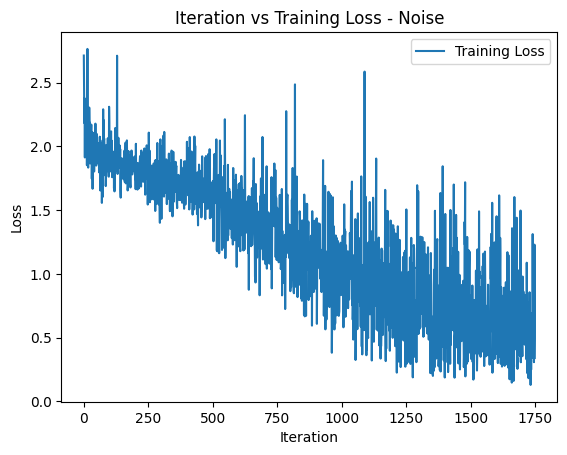

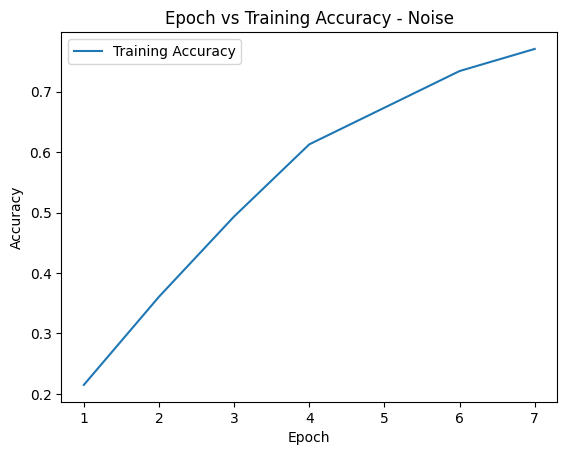

In [ ]:
# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss - Noise")
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy - Noise")
plt.legend()
plt.show()

## 6. Testing

### **Testing on clean Test Set**

**Retrieve predictions**

In [ ]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
# model.eval()
model.eval()

with torch.no_grad():
   correct = 0
   count = 0
   record = {"labels":[], "predictions":[]}

   pbar = tqdm(test_loader)
   for batch in pbar:
       input_ids = batch['input_values'].to(device)
       attention_mask = batch['attention_mask'].to(device)
       labels = batch['labels'].to(device)
       #outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
       outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
       loss = outputs['loss']

       predictions = predict(outputs)
       correct += predictions.eq(labels).sum().item()
       count += len(labels)
       accuracy = correct / count

       pbar.set_postfix({
           'loss': f'{loss.item():.3f}',
           'accuracy': f'{accuracy:.3f}'
       })

       record["labels"] += labels.cpu().numpy().tolist()
       record["predictions"] += predictions.cpu().numpy().tolist()

   pbar.close()

print(f"\nFinal test accuracy: {accuracy*100:.4f}%")

100%|██████████| 250/250 [00:20<00:00, 12.17it/s, loss=0.467, accuracy=0.952]


Final test accuracy: 95.2000%


**Analysis of the results**

In [ ]:
# Analysis
df_record = pd.DataFrame(record)
df_record.columns = ["Ground Truth", "Model Prediction"]

emotions = ["neutral", "happy", "sad", "angry", "fear", "disgust", "surprise"]
df_record["Ground Truth"] = df_record["Ground Truth"].apply(lambda x: emotions[x])
df_record["Model Prediction"] = df_record["Model Prediction"].apply(lambda x: emotions[x])

In [ ]:
# Concat test texts and test records
df = pd.concat([test_df.reset_index(), df_record["Model Prediction"]], axis=1)
#df["emotion"] = df.apply(lambda x: x["emotion"][:3], axis=1)

# Show incorrect predictions
incorrect_predictions = df[df["emotion"] != df["Model Prediction"]]
incorrect_predictions.head(10)

,index,gender,emotion,labels,source,path,aug_type,aug_params,Model Prediction
11,1370,male,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_23/03-01-03-...,clean,None,surprise
14,282,male,disgust,7,RAVDESS,./Audio_Speech_Actors_01-24/Actor_05/03-01-07-...,clean,None,angry
16,1230,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_21/03-01-04-...,clean,None,neutral
17,54,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...,clean,None,neutral
18,1177,female,fear,6,RAVDESS,./Audio_Speech_Actors_01-24/Actor_20/03-01-06-...,clean,None,sad
23,39,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...,clean,None,neutral
26,34,male,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-03-...,clean,None,surprise
27,1280,female,fear,6,RAVDESS,./Audio_Speech_Actors_01-24/Actor_22/03-01-06-...,clean,None,sad
30,1297,female,disgust,7,RAVDESS,./Audio_Speech_Actors_01-24/Actor_22/03-01-07-...,clean,None,angry
32,211,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_04/03-01-04-...,clean,None,fear


**Lets look at incorrect predictions**

In [ ]:
samples = incorrect_predictions.sample(n=3, random_state=42)
# Loop through the selected samples and display information
for idx, row in samples.iterrows():
    print(f"Sample {idx}:")
    print(f"True Emotion: {row['emotion']}")
    print(f"Predicted Emotion: {row['Model Prediction']}")
    print("Audio:")
    ipd.display(ipd.Audio(data=row["path"], autoplay=False, rate=16000))
    print("-" * 50)

Sample 210:
True Emotion: happy
Predicted Emotion: angry
Audio:


--------------------------------------------------
Sample 229:
True Emotion: fear
Predicted Emotion: surprise
Audio:


--------------------------------------------------
Sample 11:
True Emotion: happy
Predicted Emotion: surprise
Audio:


--------------------------------------------------


**Classification report**

In [ ]:
print("\nClassification Report on clean data - Noise:")
report = classification_report(
    df_record["Ground Truth"],
    df_record["Model Prediction"],
    target_names=emotions
)
print(report)


Classification Report on clean data - Noise:
              precision    recall  f1-score   support

     neutral       0.76      0.89      0.82        38
       happy       0.96      0.71      0.82        38
         sad       0.96      0.69      0.81        39
       angry       0.79      0.56      0.66        39
        fear       0.45      1.00      0.62        19
     disgust       0.70      0.54      0.61        39
    surprise       0.78      1.00      0.87        38

    accuracy                           0.75       250
   macro avg       0.77      0.77      0.74       250
weighted avg       0.80      0.75      0.75       250



**Confusion Matrix**

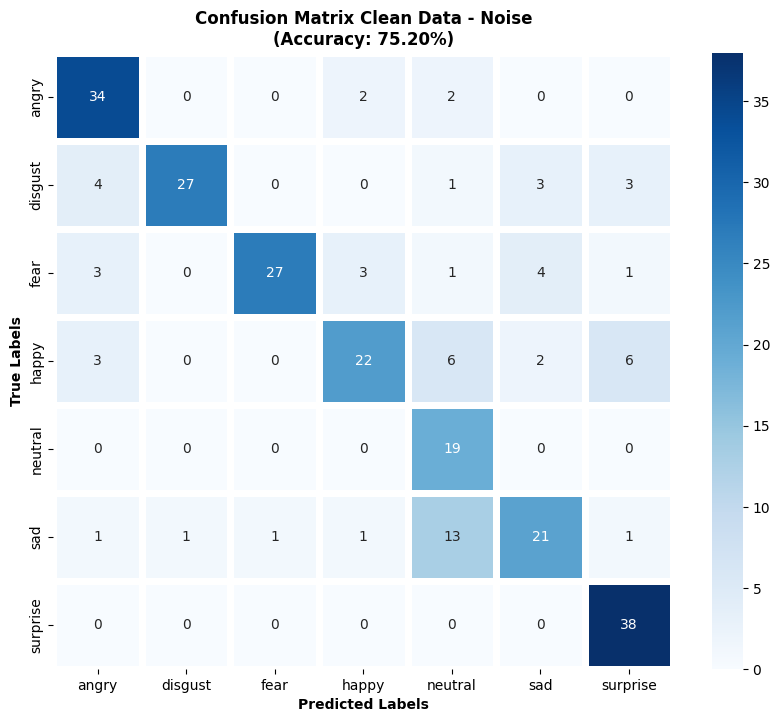

In [ ]:
# Confusion Matrix
crosstab = pd.crosstab(df_record["Ground Truth"], df_record["Model Prediction"])
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, cmap='Blues', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record)
plt.title(f"Confusion Matrix Clean Data - Noise\n(Accuracy: {accuracy*100:.2f}%)", fontweight='bold')
plt.ylabel("True Labels", fontweight='bold')
plt.xlabel("Predicted Labels", fontweight='bold')
plt.show()

### **Testing on Augmented Test Set**



=== Testing on Augmented Test Set ===



Map:   0%|          | 0/250 [00:00<?, ? examples/s]

100%|██████████| 250/250 [00:22<00:00, 11.21it/s, loss=0.332, accuracy=0.728]


Final augmented test accuracy: 72.8000%

Incorrect predictions for augmented test set:
    index  gender  emotion  labels   source  \
1       1    male  neutral       1  RAVDESS   
14     14    male  disgust       7  RAVDESS   
18     18  female     fear       6  RAVDESS   
19     19  female     fear       6  RAVDESS   
21     21  female  disgust       7  RAVDESS   
23     23    male      sad       4  RAVDESS   
27     27  female     fear       6  RAVDESS   
29     29    male     fear       6  RAVDESS   
30     30  female  disgust       7  RAVDESS   
35     35  female      sad       4  RAVDESS   

                                                 path   aug_type  aug_params  \
1   augmented/test/add_noise/1105_noise0.01_neutra...  add_noise       0.010   
14  augmented/test/add_noise/282_noise0.01_disgust...  add_noise       0.010   
18  augmented/test/add_noise/1177_noise0.005_fear.wav  add_noise       0.005   
19     augmented/test/add_noise/99_noise0.01_fear.wav  add_noise       0.01

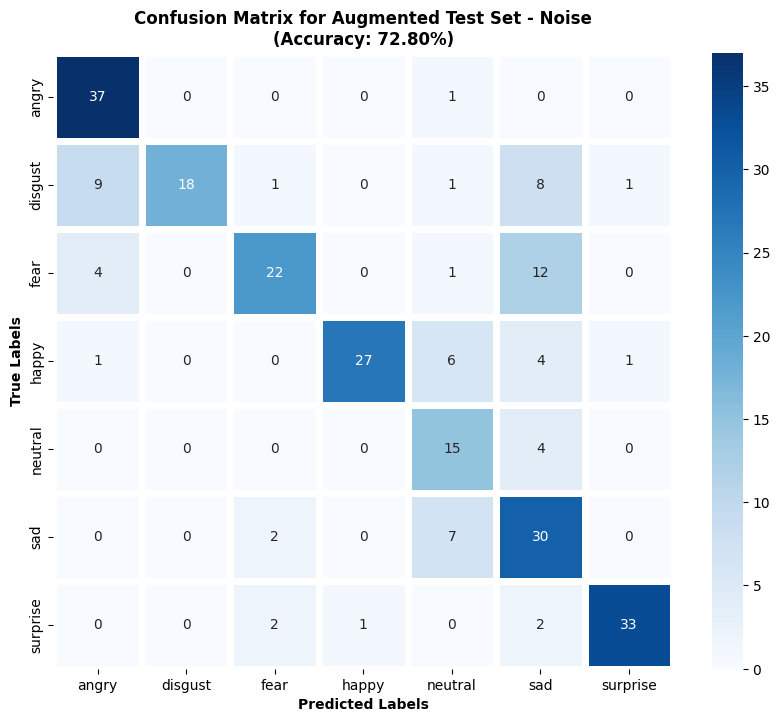

In [ ]:
print("\n=== Testing on Augmented Test Set ===\n")

# Get augmented test data by DataLoader
test_data_aug = Dataset.from_pandas(test_noisy_df).map(map_to_array)
test_aug_encodings = feature_extractor(list(test_data_aug["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_dataset_aug = EmotionDataset(test_aug_encodings, list(test_data_aug["labels"]))
test_loader_aug = DataLoader(test_dataset_aug, batch_size=1, shuffle=False)

# Start testing on augmented data
model.eval()

with torch.no_grad():
    correct = 0
    count = 0
    record = {"labels":[], "predictions":[]}

    pbar = tqdm(test_loader_aug)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']

        predictions = predict(outputs)
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct / count

        pbar.set_postfix({
            'loss': f'{loss.item():.3f}',
            'accuracy': f'{accuracy:.3f}'
        })

        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()

    pbar.close()

print(f"Final augmented test accuracy: {accuracy*100:.4f}%")

# Analysis for augmented test set
df_record_aug = pd.DataFrame(record)
df_record_aug.columns = ["Ground Truth", "Model Prediction"]

df_record_aug["Ground Truth"] = df_record_aug["Ground Truth"].apply(lambda x: emotions[x])
df_record_aug["Model Prediction"] = df_record_aug["Model Prediction"].apply(lambda x: emotions[x])

# Concat test texts and test records for augmented data
df_aug = pd.concat([test_noisy_df.reset_index(), df_record_aug["Model Prediction"]], axis=1)

# Show incorrect predictions for augmented data
incorrect_predictions_aug = df_aug[df_aug["emotion"] != df_aug["Model Prediction"]]
print("\nIncorrect predictions for augmented test set:")
print(incorrect_predictions_aug.head(10))

print("\nClassification Report for Augmented Test Set:")
report_aug = classification_report(
    df_record_aug["Ground Truth"],
    df_record_aug["Model Prediction"],
    target_names=emotions
)
print(report_aug)

# Confusion Matrix for augmented test set
plt.figure(figsize=(10, 8))
crosstab_aug = pd.crosstab(df_record_aug["Ground Truth"], df_record_aug["Model Prediction"])
sns.heatmap(crosstab_aug, cmap='Blues', annot=True, fmt='g', linewidths=5)
accuracy_aug = df_record_aug["Ground Truth"].eq(df_record_aug["Model Prediction"]).sum() / len(df_record_aug)
plt.title(f"Confusion Matrix for Augmented Test Set - Noise\n(Accuracy: {accuracy_aug*100:.2f}%)", fontweight='bold')
plt.ylabel("True Labels", fontweight='bold')
plt.xlabel("Predicted Labels", fontweight='bold')
plt.show()

### **Testing on Clean + Augmented Test Set**


=== Testing on Clean + Augmented Test Set ===



Map:   0%|          | 0/500 [00:00<?, ? examples/s]

100%|██████████| 500/500 [00:43<00:00, 11.44it/s, loss=0.832, accuracy=0.734]


Final augmented test accuracy: 73.4000%

Incorrect predictions for augmented test set:
    index  gender  emotion  labels   source  \
11     11    male    happy       3  RAVDESS   
14     14    male  disgust       7  RAVDESS   
16     16    male      sad       4  RAVDESS   
17     17    male      sad       4  RAVDESS   
18     18  female     fear       6  RAVDESS   
23     23    male      sad       4  RAVDESS   
26     26    male    happy       3  RAVDESS   
27     27  female     fear       6  RAVDESS   
30     30  female  disgust       7  RAVDESS   
32     32  female      sad       4  RAVDESS   

                                                 path aug_type  aug_params  \
11  ./Audio_Speech_Actors_01-24/Actor_23/03-01-03-...    clean         NaN   
14  ./Audio_Speech_Actors_01-24/Actor_05/03-01-07-...    clean         NaN   
16  ./Audio_Speech_Actors_01-24/Actor_21/03-01-04-...    clean         NaN   
17  ./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...    clean         NaN   
18  .

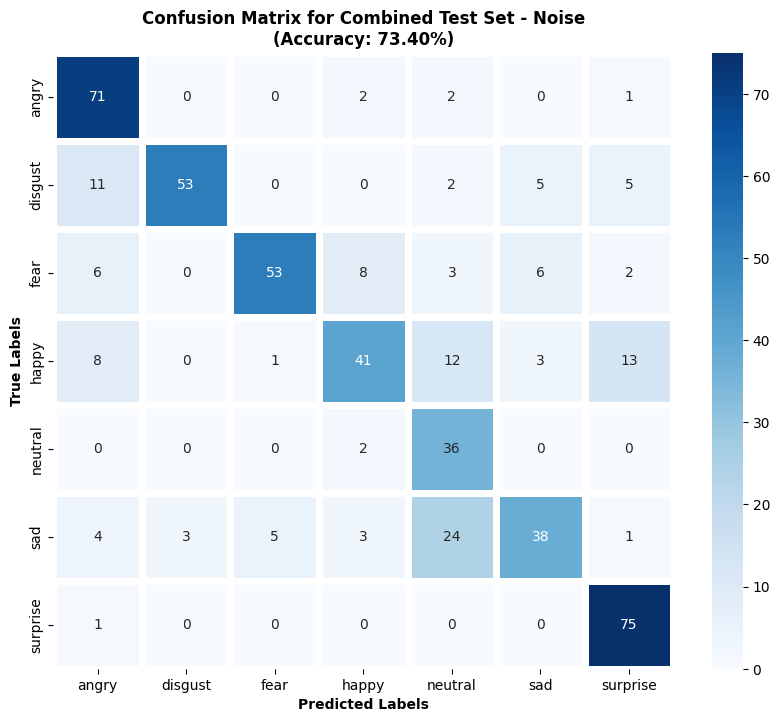

In [ ]:
print("\n=== Testing on Clean + Augmented Test Set ===\n")

# Get augmented test data by DataLoader
test_data_aug = Dataset.from_pandas(test_combined_noise).map(map_to_array)
test_aug_encodings = feature_extractor(list(test_data_aug["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_dataset_aug = EmotionDataset(test_aug_encodings, list(test_data_aug["labels"]))
test_loader_aug = DataLoader(test_dataset_aug, batch_size=1, shuffle=False)

# Start testing on augmented data
model.eval()

with torch.no_grad():
    correct = 0
    count = 0
    record = {"labels":[], "predictions":[]}

    pbar = tqdm(test_loader_aug)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']

        predictions = predict(outputs)
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct / count

        pbar.set_postfix({
            'loss': f'{loss.item():.3f}',
            'accuracy': f'{accuracy:.3f}'
        })

        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()

    pbar.close()

print(f"Final augmented test accuracy: {accuracy*100:.4f}%")

# Analysis for augmented test set
df_record_aug = pd.DataFrame(record)
df_record_aug.columns = ["Ground Truth", "Model Prediction"]

df_record_aug["Ground Truth"] = df_record_aug["Ground Truth"].apply(lambda x: emotions[x])
df_record_aug["Model Prediction"] = df_record_aug["Model Prediction"].apply(lambda x: emotions[x])

# Concat test texts and test records for augmented data
df_aug = pd.concat([test_combined_noise.reset_index(), df_record_aug["Model Prediction"]], axis=1)

# Show incorrect predictions for augmented data
incorrect_predictions_aug = df_aug[df_aug["emotion"] != df_aug["Model Prediction"]]
print("\nIncorrect predictions for augmented test set:")
print(incorrect_predictions_aug.head(10))

print("\nClassification Report for Combined Test Set - Noise:")
report_aug = classification_report(
    df_record_aug["Ground Truth"],
    df_record_aug["Model Prediction"],
    target_names=emotions
)
print(report_aug)

# Confusion Matrix for augmented test set
plt.figure(figsize=(10, 8))
crosstab_aug = pd.crosstab(df_record_aug["Ground Truth"], df_record_aug["Model Prediction"])
sns.heatmap(crosstab_aug, cmap='Blues', annot=True, fmt='g', linewidths=5)
accuracy_aug = df_record_aug["Ground Truth"].eq(df_record_aug["Model Prediction"]).sum() / len(df_record_aug)
plt.title(f"Confusion Matrix for Combined Test Set - Noise\n(Accuracy: {accuracy_aug*100:.2f}%)", fontweight='bold')
plt.ylabel("True Labels", fontweight='bold')
plt.xlabel("Predicted Labels", fontweight='bold')
plt.show()

## 7. Testing all test sets

Load the Noise model

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Load model and feature extractor from the saved path
model_path = f"{BASE_DIR}/Augmented models/Noise"
model = HubertForSequenceClassification.from_pretrained(model_path)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_path)
model.to(device)

Mounted at /content/drive


HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertLayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (pro

Load the test sets

In [ ]:
import os
import shutil
import pandas as pd
import pickle

def load_test_sets(base_dir='test_sets_backup'):
    """
    Loads all saved test sets and restores original naming with spaces
    """
    loaded_sets = {}

    # Go through each folder in the base directory
    for set_folder in os.listdir(base_dir):
        if os.path.isdir(os.path.join(base_dir, set_folder)):
            # Load the DataFrame
            df_path = os.path.join(base_dir, set_folder, 'metadata.pkl')
            if os.path.exists(df_path):
                # Convert folder name back to original format (replace underscores with spaces)
                original_name = set_folder.replace('_', ' ')
                loaded_sets[original_name] = pd.read_pickle(df_path)

    return loaded_sets

In [ ]:
# Load all test sets
loaded_test_sets = load_test_sets(f"{BASE_DIR}/Datasets/RAVDNESS/test_sets")

# Select only relevant test sets for noise model
noise_relevant_sets = {
    'Clean': loaded_test_sets['Clean'],
    'Noise': loaded_test_sets['Noise'],
    'Combined Noise': loaded_test_sets['Combined Noise']
}

**Function to test a single test set**

In [ ]:
def evaluate_test_set(model, test_df, set_name, device, feature_extractor):
    """
    Evaluates model performance on a given test set and generates analysis

    Args:
        model: The trained model
        test_df: DataFrame containing test data
        set_name: String identifying the test set (e.g., 'Noise', 'Time Stretch')
        emotions: List of emotion labels
        device: torch device
        feature_extractor: HuBERT feature extractor
    """
    # Ensure model is in eval mode and gradients are disabled
    model.eval()
    for param in model.parameters():
        param.requires_grad = False

    # Prepare data
    test_data = Dataset.from_pandas(test_df).map(map_to_array)
    test_encodings = feature_extractor(
        list(test_data["speech"]),
        sampling_rate=16000,
        padding=True,
        return_tensors="pt"
    )
    test_dataset = EmotionDataset(test_encodings, list(test_data["labels"]))
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Testing loop
    with torch.no_grad():
        correct = 0
        count = 0
        record = {"labels": [], "predictions": []}

        pbar = tqdm(test_loader, desc=f"Testing {set_name}")
        for batch in pbar:
            input_ids = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            predictions = predict(outputs)
            correct += predictions.eq(labels).sum().item()
            count += len(labels)
            accuracy = correct / count

            pbar.set_postfix({
                'loss': f'{outputs["loss"].item():.3f}',
                'accuracy': f'{accuracy:.3f}'
            })

            record["labels"] += labels.cpu().numpy().tolist()
            record["predictions"] += predictions.cpu().numpy().tolist()

        pbar.close()

    # Analysis
    df_record = pd.DataFrame(record)
    df_record.columns = ["Ground Truth", "Model Prediction"]
    emotions = ["neutral", "happy", "sad", "angry", "fear", "disgust", "surprise"]
    df_record["Ground Truth"] = df_record["Ground Truth"].apply(lambda x: emotions[x])
    df_record["Model Prediction"] = df_record["Model Prediction"].apply(lambda x: emotions[x])

    # Results printing
    print(f"\n=== Results for {set_name} ===")
    print(f"Final accuracy: {accuracy*100:.4f}%")

    # Classification report
    print(f"\nClassification Report for Noise model on {set_name} test set:")
    report = classification_report(
        df_record["Ground Truth"],
        df_record["Model Prediction"],
        target_names=emotions
    )
    print(report)

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    crosstab = pd.crosstab(df_record["Ground Truth"], df_record["Model Prediction"])
    sns.heatmap(crosstab, cmap='Blues', annot=True, fmt='g', linewidths=5)
    plt.title(f"Confusion Matrix for Noise model - {set_name} test set\n(Accuracy: {accuracy*100:.2f}%)",
              fontweight='bold')
    plt.ylabel("True Labels", fontweight='bold')
    plt.xlabel("Predicted Labels", fontweight='bold')
    plt.show()

    return accuracy, df_record

**All test datasets saved**


Evaluating Noise Model on Clean dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing Clean: 100%|██████████| 250/250 [00:24<00:00, 10.01it/s, loss=1.537, accuracy=0.756]



=== Results for Clean ===
Final accuracy: 75.6000%

Classification Report for Noise model on Clean test set:
              precision    recall  f1-score   support

     neutral       0.83      0.89      0.86        38
       happy       1.00      0.74      0.85        38
         sad       0.89      0.79      0.84        39
       angry       0.90      0.49      0.63        39
        fear       0.38      1.00      0.55        19
     disgust       0.85      0.56      0.68        39
    surprise       0.73      0.95      0.83        38

    accuracy                           0.76       250
   macro avg       0.80      0.78      0.75       250
weighted avg       0.83      0.76      0.76       250



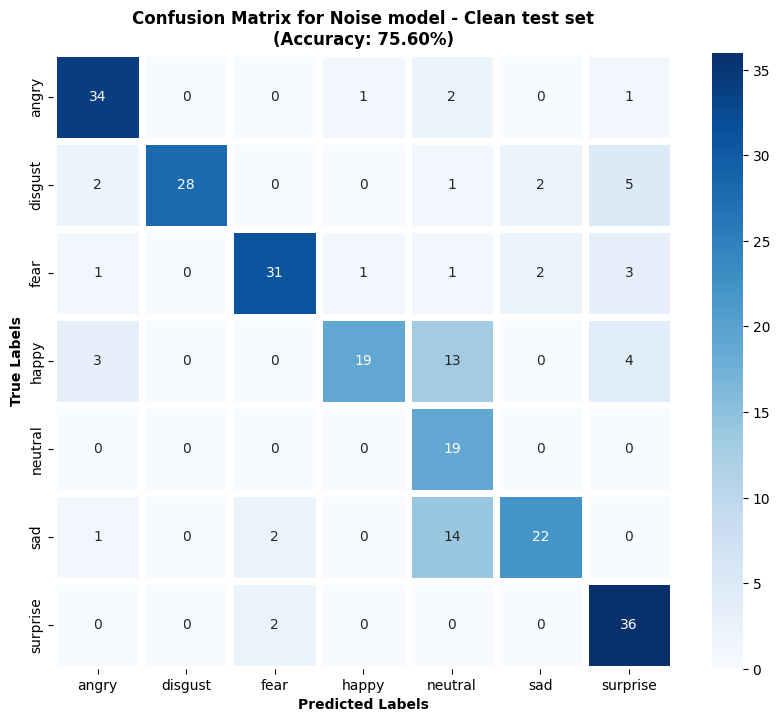


Evaluating Noise Model on Noise dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing Noise: 100%|██████████| 250/250 [00:23<00:00, 10.73it/s, loss=0.280, accuracy=0.680]



=== Results for Noise ===
Final accuracy: 68.0000%

Classification Report for Noise model on Noise test set:
              precision    recall  f1-score   support

     neutral       0.68      0.95      0.79        38
       happy       0.91      0.55      0.69        38
         sad       0.85      0.59      0.70        39
       angry       0.84      0.54      0.66        39
        fear       0.35      0.89      0.50        19
     disgust       0.77      0.44      0.56        39
    surprise       0.69      0.92      0.79        38

    accuracy                           0.68       250
   macro avg       0.73      0.70      0.67       250
weighted avg       0.76      0.68      0.68       250



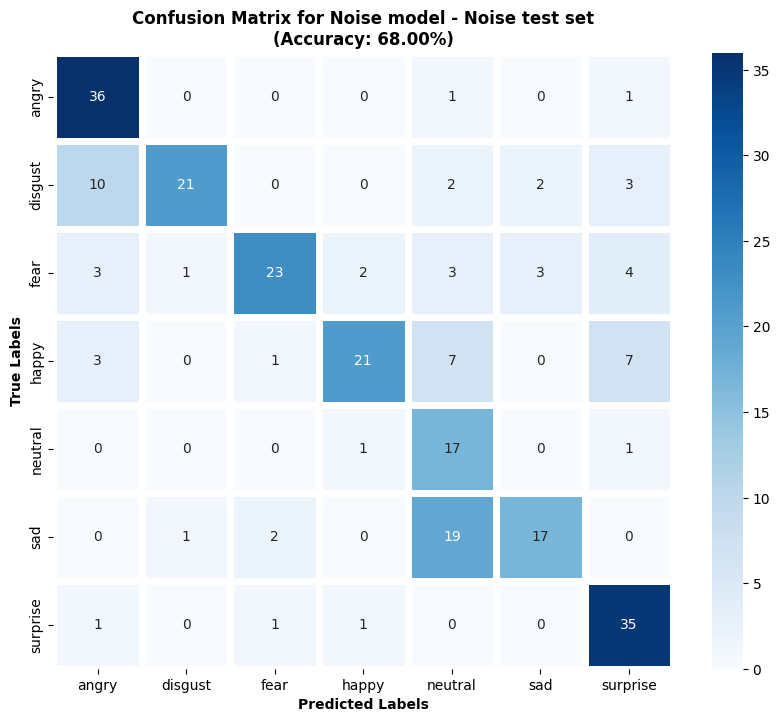


Evaluating Noise Model on Combined Noise dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Testing Combined Noise: 100%|██████████| 500/500 [00:47<00:00, 10.52it/s, loss=0.280, accuracy=0.718]



=== Results for Combined Noise ===
Final accuracy: 71.8000%

Classification Report for Noise model on Combined Noise test set:
              precision    recall  f1-score   support

     neutral       0.74      0.92      0.82        76
       happy       0.96      0.64      0.77        76
         sad       0.87      0.69      0.77        78
       angry       0.87      0.51      0.65        78
        fear       0.36      0.95      0.53        38
     disgust       0.81      0.50      0.62        78
    surprise       0.71      0.93      0.81        76

    accuracy                           0.72       500
   macro avg       0.76      0.74      0.71       500
weighted avg       0.79      0.72      0.72       500



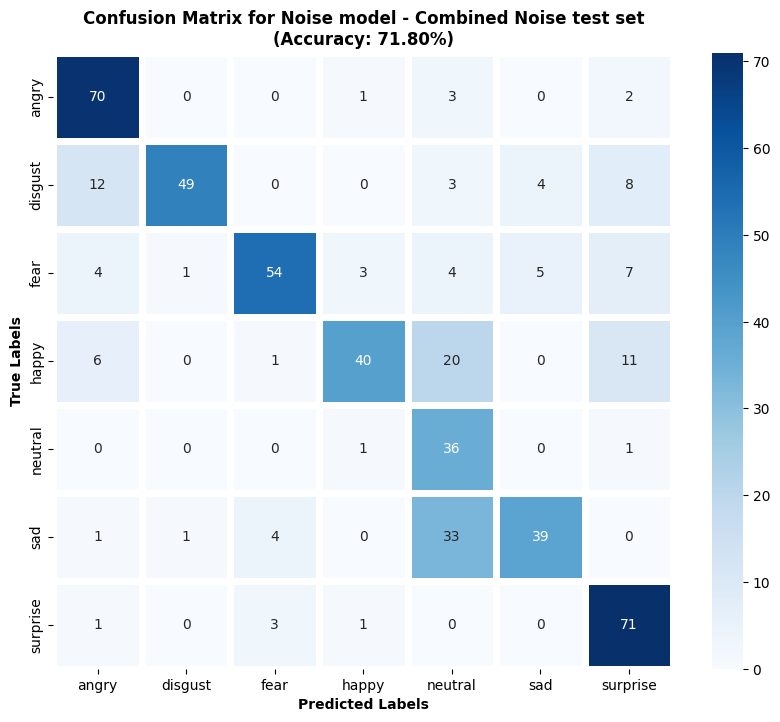

In [ ]:
# Evaluate noise model only on relevant sets
results = {}
for set_name, test_data in noise_relevant_sets.items():
    print(f"\nEvaluating Noise Model on {set_name} dataset...")
    accuracy, df_record = evaluate_test_set(
        model,
        test_data,
        set_name,
        device,
        feature_extractor
    )
    results[set_name] = {'accuracy': accuracy, 'record': df_record}